## Basics

In [3]:
import numpy as np
import pandas as pd
import matplotlib as plt
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [4]:
#read csv and make a panda dataframe with columns header
df = pd.read_csv("laptops.csv")
df.head()

,Laptop,Status,Brand,Model,CPU,RAM,Storage,Storage type,GPU,Screen,Touch,Final Price
0,ASUS ExpertBook B1 B1502CBA-EJ0436X Intel Core...,New,Asus,ExpertBook,Intel Core i5,8,512,SSD,NaN,15.6,No,1009.00
1,Alurin Go Start Intel Celeron N4020/8GB/256GB ...,New,Alurin,Go,Intel Celeron,8,256,SSD,NaN,15.6,No,299.00
2,ASUS ExpertBook B1 B1502CBA-EJ0424X Intel Core...,New,Asus,ExpertBook,Intel Core i3,8,256,SSD,NaN,15.6,No,789.00
3,MSI Katana GF66 12UC-082XES Intel Core i7-1270...,New,MSI,Katana,Intel Core i7,16,1000,SSD,RTX 3050,15.6,No,1199.00
4,HP 15S-FQ5085NS Intel Core i5-1235U/16GB/512GB...,New,HP,15S,Intel Core i5,16,512,SSD,NaN,15.6,No,669.01


In [5]:
#normalize columns'names
df.columns = df.columns.str.lower().str.replace(' ', '_')
df.columns

Index(['laptop', 'status', 'brand', 'model', 'cpu', 'ram', 'storage',
       'storage_type', 'gpu', 'screen', 'touch', 'final_price'],
      dtype='object')

In [380]:
for col in df.columns:
    print(col,df[col].isnull().sum()) if df[col].isna().any() else None

storage_type 42
gpu 1371
screen 4


In [9]:
#Question 1
df_f = df[["ram","storage","screen","final_price"]]
df_f.isna().any()

ram            False
storage        False
screen          True
final_price    False
dtype: bool

In [382]:
for col in df[["ram","storage","screen","final_price"]]:
    print(col,df[col].isnull().sum()) if df[[col]].isna().any().any() else None

screen 4


In [383]:
for col in df_f.columns:
    print(col,df_f[col].isnull().sum()) if df_f[[col]].isna().any().any() else None

screen 4


In [384]:
#Question 2
df_f.ram.median()

16.0

In [385]:
#shuffle data
n = len(df_f)
n_val = int(0.2 * n)
n_test = int(0.2 * n)
n_train = n - n_val - n_test

np.random.seed(42)

idx = np.arange(n)
np.random.shuffle(idx)

df_shuffled = df_f.iloc[idx]

df_train = df_shuffled.iloc[:n_train].copy()
df_val = df_shuffled.iloc[n_train : n_train + n_val].copy()
df_test = df_shuffled.iloc[n_train + n_val : ].copy()

In [386]:
y_train_orig = df_train.final_price.values
y_val_orig = df_val.final_price.values
y_test_orig = df_test.final_price.values

y_train = np.log1p(df_train.final_price.values)
y_val = np.log1p(df_val.final_price.values)
y_test = np.log1p(df_test.final_price.values)

del df_train["final_price"]
del df_val["final_price"]
del df_test["final_price"]

In [387]:
def train_linear_regression(X,y):
    
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])
    
    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]

In [388]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1296 entries, 2079 to 796
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   ram      1296 non-null   int64  
 1   storage  1296 non-null   int64  
 2   screen   1293 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 40.5 KB


## ZEROS

In [6]:
def prepare_X_zeros(df):
    df_num = df.fillna(0)
    X = df_num.values
    return X

In [390]:
X_train = prepare_X_zeros(df_train)
w_0, w = train_linear_regression(X_train, y_train)

In [391]:
y_pred = w_0 + X_train.dot(w)

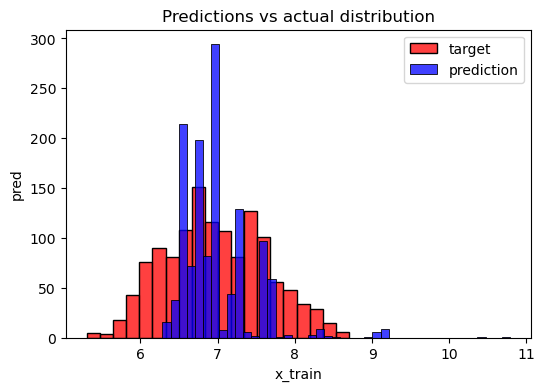

In [402]:
plt.figure(figsize=(6, 4))

sns.histplot(y_train, label='target', color='red')
sns.histplot(y_pred, label='prediction', color='blue')

plt.legend()

plt.ylabel('pred')
plt.xlabel('x_train')
plt.title('Predictions vs actual distribution')

plt.show()

In [8]:
def rmse (y,y_pred):

    error = y_pred - y
    mse = (error**2).mean()

    return np.sqrt(mse)

In [404]:
rmse_train_zeros = rmse(y_train, y_pred).round(2)

In [405]:
X_val = prepare_X_zeros(df_val)
y_pred_val = w_0 + X_val.dot(w)

In [406]:
rmse_val_zeros = rmse(y_val, y_pred_val).round(2)

In [407]:
rmse_train_zeros, rmse_val_zeros

(0.45, 0.43)

## MEAN

In [260]:
def prepare_X_mean(df):
    df_num = df.fillna(df.mean())
    X = df_num.values
    return X

In [261]:
X_train = prepare_X_mean(df_train)
w_0, w = train_linear_regression(X_train, y_train)

In [262]:
y_pred = w_0 + X_train.dot(w)

In [263]:
rmse_train_mean = rmse(y_train, y_pred).round(2)

In [264]:
X_val = prepare_X_mean(df_val)
y_pred_val = w_0 + X_val.dot(w)

In [265]:
rmse_val_mean = rmse(y_val, y_pred_val).round(2)

In [266]:
rmse_train_mean, rmse_val_mean

(0.45, 0.43)

## Regularized linear regression

In [7]:
def train_linear_regression_reg(X,y, r=0):
    
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])
    
    XTX = X.T.dot(X)
    reg = r * np.eye(XTX.shape[0])
    XTX = XTX + reg
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]

In [269]:
X_train = prepare_X_zeros(df_train)
w_0, w = train_linear_regression_reg(X_train, y_train)

In [273]:
for r in [0, 0.01, 0.1, 1, 5, 10, 100]:
    w_0, w = train_linear_regression_reg(X_train, y_train, r=r)
    y_pred = w_0 + X_val.dot(w)
    print("%10s"  %r, rmse(y_val, y_pred).round(2))

         0 0.43
      0.01 0.43
       0.1 0.43
         1 0.43
         5 0.45
        10 0.48
       100 0.6


## RMSE spread

In [293]:
seeds = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [366]:
rmse_scores = []
for s in seeds:
    
    n = len(df_f)
    n_val = int(0.2 * n)
    n_test = int(0.2 * n)
    n_train = n - n_val - n_test

    np.random.seed(s)

    idx = np.arange(n)
    np.random.shuffle(idx)
    
    df_shuffled = df_f.iloc[idx]
    
    df_train = df_shuffled.iloc[:n_train].copy()
    df_val = df_shuffled.iloc[n_train : n_train + n_val].copy()
    df_test = df_shuffled.iloc[n_train + n_val : ].copy()

    y_train_orig = df_train.final_price.values
    y_val_orig = df_val.final_price.values
    y_test_orig = df_test.final_price.values
    
    y_train = (df_train.final_price.values)
    y_val = (df_val.final_price.values)
    y_test = (df_test.final_price.values)
    
    del df_train["final_price"]
    del df_val["final_price"]
    del df_test["final_price"]

    X_train = prepare_X_zeros(df_train)
    X_val = prepare_X_zeros(df_val)
    
    w_0, w = train_linear_regression(X_train, y_train)
    y_pred_val = w_0 + X_val.dot(w)

    rmse_scores.append(rmse(y_val, y_pred_val))    

In [367]:
rmse_scores

[565.4520868770995,
 636.7985423056726,
 588.955869790796,
 597.8148920012515,
 571.962791511103,
 573.238325661895,
 647.3438328407194,
 550.4398184485962,
 587.3335036169963,
 576.101792943313]

In [368]:
rmse_std = np.std(rmse_scores)
print(rmse_std.round(3))

29.176


## RMSE test

In [11]:
n = len(df_f)
n_train_val = int(0.8 * n)

n_test = n - n_train_val

np.random.seed(9)

idx = np.arange(n)
np.random.shuffle(idx)

df_shuffled = df_f.iloc[idx]

df_train = df_shuffled.iloc[:n_train_val].copy()
df_test = df_shuffled.iloc[n_train_val :].copy()


y_train = (df_train.final_price.values)
y_test = (df_test.final_price.values)

del df_train["final_price"]
del df_test["final_price"]


X_train = prepare_X_zeros(df_train)
X_test = prepare_X_zeros(df_test)

w_0, w = train_linear_regression_reg(X_train, y_train,r=0.001)
y_pred_test = w_0 + X_test.dot(w)


print((rmse(y_test, y_pred_test)))

608.6099822049559
